# 1-D Poisson equation

This notebook is dedicated to solve the 1-dimensional poisson equation using Physics Inform Neural Network (PINN).


$\frac{d^{2} u(x)}{dx^2} = f(x), x ∈ [0,1]$

The boundary conditions will be:

$u(0) = 0, u(1) = 0$

Whit the PINN the idea is to determine $u(x)$ and $f(x) = -2$ would be know in order to get an analitical solution to the problem.

The first thing is to find the analytical solution to the equation.

## Analytical solution

$\frac{d^{2} u(x)}{dx^2} = f(x)$

Integrate both sides of the differential equation (DE).

$\int{\frac{d^{2} u(x)}{dx^2} dx} = \int{-2} dx$

$\frac{d u(x)}{dx} = -2x + c_1$

Again, integrate both sides of the DE

$\int{\frac{d u(x)}{dx} dx} = \int{-2x + c_1} dx$

$u(x) = -x^2 + c_1  x + c_2$

Now, using the boundary conditions:

$u(0) = c_2 = 0$

$u(1) = -1 + c_1 = 0$

So, $c_1 = 1$ and $c_2 = 0$

Finally, the solution $u(x)$ is:

$u(x) = x(1-x)$

## PINNs solution: Pytorch approach

In [3]:
import warnings 
warnings.filterwarnings('ignore') 

In [4]:
import torch #Import Pytorch - open source ML library used for creating deep neural networks 
import torch.nn as nn #Import neural network module
import numpy as np

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #checks for GPU

To start, it is necessary to define the dominion of the problem. In this case is $[0,1]$. Also, the amount of point that will be taken inside the work domain is defined.

In [6]:
x = torch.linspace(0, 1, 100, requires_grad=True).to(device) 
#requires_grad = True - tell autograd to begin recording operations on a Tensor 

In [7]:
def f(x):
    return -2 * torch.ones_like(x) #f(x) becomes a tensor. 
#torch.ones_like(x) creates a tensor full with ones

In [8]:
class PINN(nn.Module): #Clase que hereda el modulo de redes neuronales
    def __init__(self):  #Constructor
        super(PINN, self).__init__()
        #Here it's define the neural network structure
        self.hidden = nn.Sequential( #Sequential layers
                nn.Linear(1, 32), #Linear layer 1 entry, 32 neurons
                nn.Tanh(), #activation function. It introduces no linearity. Tanh is soft and differentiable.
                nn.Linear(32, 32), #Linear layer 32 inputs, 32 neurons
                nn.Tanh(), #activation function.
                nn.Linear(32, 1) #Final layer, 32 inputs, 1 output which consist of u(x)
        )
    
    def forward(self, x): #Defines how the data passes through the network to produce an output.
        return self.hidden(x) #Passes data through NN structure in a sequential way

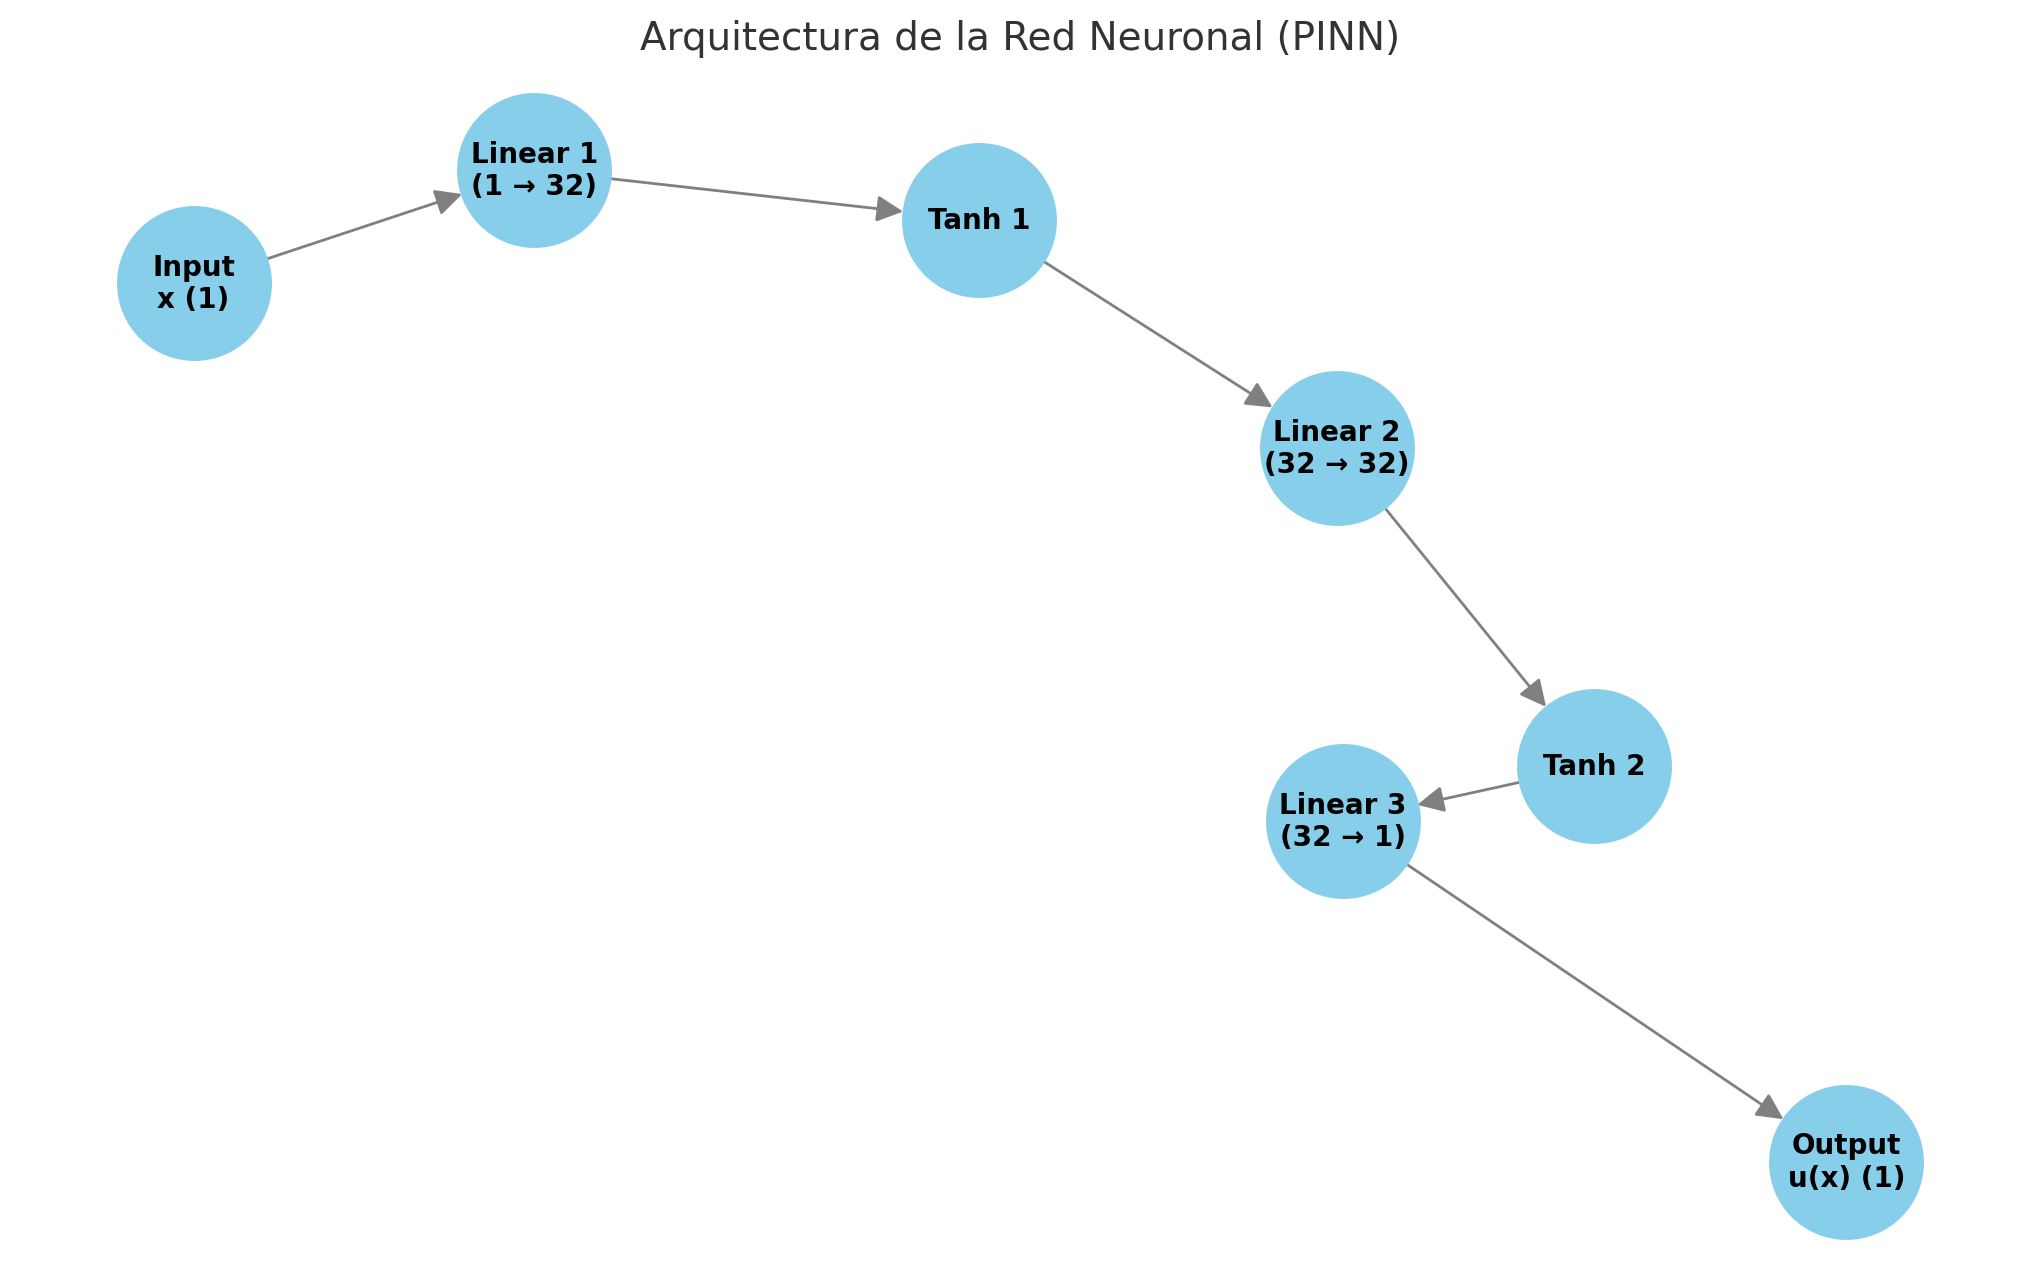

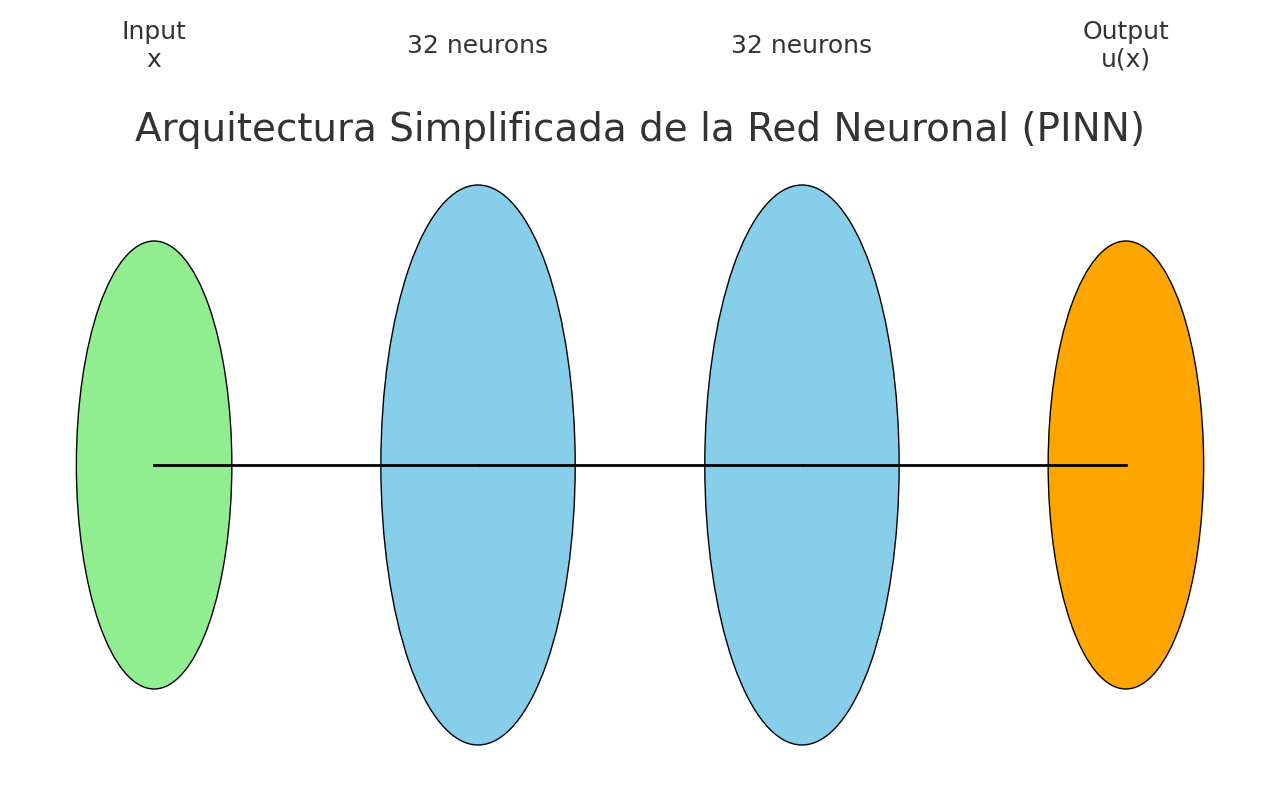

In [9]:
model = PINN().to(device)

Now, the loss function is defined. The loss function consist of two terms.

**Differential equation:** 

$L_{poisson} = \left|\left|\frac{d^2 u}{dx^2} - f(x) \right|\right|^2$

**Boundary Conditions:**

$L_{BC} = \left|u(0)\right|^2 + \left|u(1)\right|^2$

In [10]:
# Definir la función de pérdida
def loss_f(model, x):
    u = model(x) #Prediction
    
    #Derivatives calculation
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0] #First derivative
    #Calculates the gradient of a tensor u respect to x tensor
    #grad_outputs=torch.ones_like(u) - each element of u contributes equally to the final gradient
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0] #Second derivative
    
    loss_poisson = torch.mean((u_xx - f(x))**2) #Calculates the loss function due to the differential equation
    #The mean is taken to take into account all the points that are being evaluated
    
    #Calculate the loss function due to the boundary conditions
    loss_bc = model(torch.tensor([[0.0]], device=device))**2 + model(torch.tensor([[1.0]], device=device))**2 
    
    return loss_poisson + loss_bc

In [11]:
# Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Entrenamiento
epochs = 5000
loss_history = []
for epoch in range(epochs):
    optimizer.zero_grad() #clear the gradients of all the parameters before the backward pass.
    loss = loss_f(model, x.unsqueeze(1)) #Adding a new dimension to the input data
    loss.backward() #compute the gradients of the loss function with respect to the parameters.
    optimizer.step() #update the parameters of the model using the computed gradients and the Adam optimization algorithm.
        
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.10f}")

Epoch 0, Loss: 4.1736307144
Epoch 500, Loss: 0.0000304998
Epoch 1000, Loss: 0.0000030625
Epoch 1500, Loss: 0.0000046619
Epoch 2000, Loss: 0.0000066409
Epoch 2500, Loss: 0.0000077926
Epoch 3000, Loss: 0.0000069173
Epoch 3500, Loss: 0.0000177694
Epoch 4000, Loss: 0.0041784430
Epoch 4500, Loss: 0.0003788974


In [12]:
import matplotlib.pyplot as plt

Mean Squared Error (MSE): 0.011545742861926556


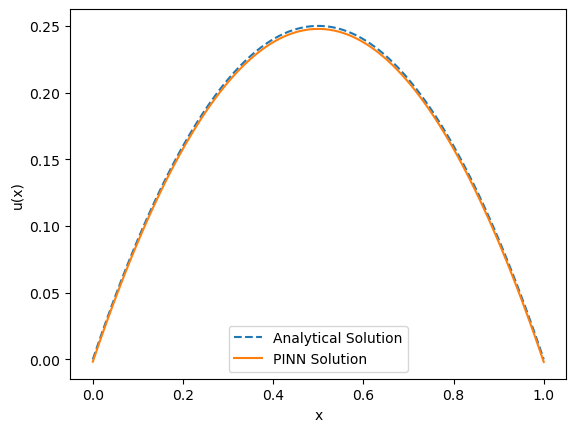

In [14]:
mse = torch.mean((model(x.unsqueeze(1)) - x*(1-x))**2)
print(f"Mean Squared Error (MSE): {mse.item()}")
# Analitic Solution
x_np = x.detach().cpu().numpy() #Convert pythorch tensor to nummpy array
u_exact = x_np * (1 - x_np) #Analytical solution

# PINN solution
u_pinn = model(x.unsqueeze(1)).detach().cpu().numpy() 

plt.plot(x_np, u_exact, label="Analytical Solution", linestyle="dashed")
plt.plot(x_np, u_pinn, label="PINN Solution", linestyle="solid")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.show()

The PINN works really good. In this example no tunning was done and a simple neural network was able to find a really good solution. In this point i realized that it would be interest to see if applying a symbolic regression would get me to the original analytic solution. So, the rest of the notebook will be the implementation of a symbolic regression.

## Symbolic regression

In [15]:
import os
os.environ["PYTHONUNBUFFERED"] = "1"
from pysr import PySRRegressor #symbolic regression

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [16]:
#Convert tensors from Pytorch to numpy arrays
x_np = x.cpu().detach().numpy().flatten()
u_pinn_np = model(x.unsqueeze(1)).detach().cpu().numpy().flatten()

In [17]:
model_syr = PySRRegressor(
    niterations=1000,  #Number of iterations
    binary_operators=["+", "-", "*", "/"], #Define the binary operators that will be used
    unary_operators=["sin", "cos", "exp", "log"],  #Unary operators: a mathematical operation that works on a single operand
    populations=20,  # Maintain 20 candidate equations in each generation
    loss="loss(x, y) = (x - y)^2",  #MSE error
    verbosity=1  
)

In [18]:
print("Training...")
model_syr.fit(x_np.reshape(-1, 1), u_pinn_np) #Fit symbolic regression with PINNs data

Training...
Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 2.340e+05
Progress: 1375 / 5000 total iterations (27.500%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           5.761e-03  1.594e+01  y = 0.16286
4           5.529e-03  1.367e-02  y = cos(x₀) * 0.19191
5           1.062e-06  8.557e+00  y = x₀ * (0.99679 - x₀)
6           8.590e-07  2.121e-01  y = sin((0.99851 - x₀) * x₀)
7           1.716e-08  3.913e+00  y = ((0.99982 - x₀) * x₀) - 0.0020291
9           5.398e-11  2.881e+00  y = ((0.99809 - (x₀ * 0.99828)) * x₀) - 0.0017452
11          5.389e-11  7.877e-04  y = (((1.9981 - (x₀ * 0.99828)) * x₀) + -0.0017453) - x₀
13          5.383e-11  6.225e-04  y = ((-0.001745 + (x₀ * (2.9981 - (x₀ * 0.99828)))) - x₀) ...
                                      - x₀
14          5.361e-11  4.035e-03  y = ((0.99915 - x₀)

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           5.761e-03  1.594e+01  y = 0.16286
4           5.529e-03  1.367e-02  y = cos(x₀) * 0.19191
5           1.062e-06  8.557e+00  y = (0.99679 - x₀) * x₀
6           8.590e-07  2.121e-01  y = sin((0.99851 - x₀) * x₀)
7           1.716e-08  3.913e+00  y = (0.99778 - x₀) * (x₀ - 0.0020338)
9           5.396e-11  2.881e+00  y = (x₀ * ((0.99981 - x₀) * 0.99828)) - 0.0017453
11          5.387e-11  7.837e-04  y = (((2.0015 - x₀) * (x₀ * 0.99828)) + -0.0017452) - x₀
13          5.382e-11  5.024e-04  y = (((x₀ * (2.9981 - (x₀ * 0.99828))) + -0.0017451) - x₀)...
                                       - x₀
14          5.302e-11  1.497e-02  y = (((0.99933 - x₀) * x₀) * 0.99874) - (cos(x₀ * -0.75921...
                                      ) * 0.0017433)
15          5.292e-11  1.870e-03  y = ((0.99957 - x₀) * (x₀ * 0.9985)) - (cos(sin(x₀ * 0.557...
  

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         0.16286358   
	1         0.013668                               cos(x0) * 0.19190785   
	2         8.557722                              (0.9967882 - x0) * x0   
	3         0.212051                         sin((0.9985111 - x0) * x0)   
	4         3.913315            (0.99778193 - x0) * (x0 - 0.0020337554)   
	5         2.881004  (x0 * ((0.99981487 - x0) * 0.99827987)) - 0.00...   
	6         0.000784  (((2.001538 - x0) * (x0 * 0.9982798)) + -0.001...   
	7         0.000502  (((x0 * (2.9980943 - (x0 * 0.99827904))) + -0....   
	8         0.014972  (((0.9993311 - x0) * x0) * 0.9987415) - (cos(x...   
	9         0.001870  ((0.9995705 - x0) * (x0 * 0.9984958)) - (cos(s...   
	10        0.639636  ((0.9977972 - (x0 * 0.9979935)) * x0) - (cos((...   
	11        1.008671  ((0.99981034 - x0) * (x0 * 0.9983204)) - (cos(...   
	12        0.020064  ((x0 * 0.99831146) * (0.99981135 - x0)) - (cos...   
	13        0.955554  ((0.999825 - x0) * (x0 * 0.9982957)) - (cos(co...   
	14        0.722484  (x0 * ((0.9998287 - x0) * 0.99828714)) - (cos(...   
	15        0.262207  ((x0 * (0.9998371 - x0)) * 0.99830806) - (cos(...   
	16        0.619437  ((x0 * (0.99983084 - x0)) * 0.9982978) - (cos(...   
	17        0.186170  (0.9983045 * (x0 * (0.99982804 - x0))) - (cos(...   
	18        0.702135  (x0 * ((0.99983126 - x0) * 0.9982941)) - (cos(...   
	19  >>>>  0.219488  ((x0 * (0.99983084 - x0)) * 0.99828935) - (cos...   
	
	            loss  complexity  
	0   5.760686e-03           1  
	1   5.529245e-03           4  
	2   1.061926e-06           5  
	3   8.590174e-07           6  
	4   1.715817e-08           7  
	5   5.395885e-11           9  
	6   5.387434e-11          11  
	7   5.382022e-11          13  
	8   5.302043e-11          14  
	9   5.292138e-11          15  
	10  2.791521e-11          16  
	11  1.018077e-11          17  
	12  9.780316e-12          19  
	13  3.761500e-12          20  
	14  1.826377e-12          21  
	15  1.405126e-12          22  
	16  7.563055e-13          23  
	17  6.278339e-13          24  
	18  3.111083e-13          25  
	19  2.005703e-13          27  
]

In [19]:
# Show expressions
print("Symbolic expressions:")
print(model_syr)

Symbolic expressions:
PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         0.16286358   
	1         0.013668                               cos(x0) * 0.19190785   
	2         8.557722                              (0.9967882 - x0) * x0   
	3         0.212051                         sin((0.9985111 - x0) * x0)   
	4         3.913315            (0.99778193 - x0) * (x0 - 0.0020337554)   
	5         2.881004  (x0 * ((0.99981487 - x0) * 0.99827987)) - 0.00...   
	6         0.000784  (((2.001538 - x0) * (x0 * 0.9982798)) + -0.001...   
	7         0.000502  (((x0 * (2.9980943 - (x0 * 0.99827904))) + -0....   
	8         0.014972  (((0.9993311 - x0) * x0) * 0.9987415) - (cos(x...   
	9         0.001870  ((0.9995705 - x0) * (x0 * 0.9984958)) - (cos(s...   
	10        0.639636  ((0.9977972 - (x0 * 0.9979935)) * x0) - (cos((...   
	11        1.008671  ((0.99981034 - x0) * (x0 * 0.9983204)) -

In [29]:
#Pick expresion with the best score (Relation between complexity and loss)
best_equation = model_syr.equations_.sort_values(by="score", ascending = False).iloc[0]
print(best_equation)

complexity                                          5
loss                                         0.000001
equation                        (0.9967882 - x0) * x0
score                                        8.557722
sympy_format                      x0*(0.9967882 - x0)
lambda_format    PySRFunction(X=>x0*(0.9967882 - x0))
Name: 2, dtype: object


Using a physics informed neural network followed by a symbolic regression i obtain the following expresion:

$u(x) = x (0.9967882 - x)$

which is basically the original analytical expresion